## Python Code : WOE and IV

There are three methods that I have tested:

1. Python function shared by [Deepanshu Bhalia](https://www.linkedin.com/in/deepanshubhalla/) and adjusted for mobile application specifications (max_bins=6)
2. Functions from the [pywoe](https://github.com/Densur/PyWoE/blob/master/woe.py) package by [Denis Surzhko](https://www.linkedin.com/in/denis-surzhko-phd-prm-61135031/?originalSubdomain=ru)
3. Using the category_encoders library.

In [1]:
# Load Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read Data
trainDF = pd.read_csv("../../data/cs-training.csv")

### 4-step WOE calculation with python function

The decision was made to run through this process twice to determine the scale for positive and negative values. It is expected that the the first run with the raw data containing missing values (`trainDF`) will output a scale where positive and negative values are based on a 1 value scale(eg. neg: 0.45, pos: 1.56). The second run with `processed_trainDF` does not contain missing values with top-coding for outliers is based on zero (eg. neg: -0.034, pos: 0.035)

See Weight of Evidence Report for more information.

In [3]:
# Load Required Packages
import pandas as pd
import numpy as np

In [4]:
# Test for 1-scale
trainDF.drop(columns=['Unnamed: 0'], inplace=True)
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [5]:
# Select a target
target_col = 'SeriousDlqin2yrs'

In [6]:
# (optional) set bin limits
NumberOfDependents_bins = pd.IntervalIndex.from_tuples([(-0.02, 1), (2,20)])
RevolvingUtilizationOfUnsecuredLines_bins = pd.IntervalIndex.from_tuples([(0, 0.49), (0.5, 0.99), (1, 1.49), (1.5, 60_000)])
age_bins = pd.IntervalIndex.from_tuples([(0,17), (18, 25), (26, 34), (35, 44), (45, 64), (65, 120)])
NumberOfTime3059DaysPastDueNotWorse_bins = pd.IntervalIndex.from_tuples([(-0.098, 0.99), (1, 1.99), (2, 100)])
DebtRatio_bins = pd.IntervalIndex.from_tuples([(0, .31249), (.3125, .6249), (0.625, 2.49), (2.5,150_000)])
MonthlyIncome_bins = pd.IntervalIndex.from_tuples([(0,4999), (5000,9999), (10_000,1_000_000)])
NumberOfOpenCreditLinesAndLoans_bins = pd.IntervalIndex.from_tuples([(-0.058, 11.59), (11.6, 17.39), (17.4, 58.0)])
NumberOfTimes90DaysLate_bins = pd.IntervalIndex.from_tuples([(-0.098, 1), (1.01, 1.49), (1.5, 4.9), (5, 9.9), (10, 98.0)])
NumberRealEstateLoansOrLines_bins = pd.IntervalIndex.from_tuples([(0, 0.49), (0.5,0.99), (1,2.9), (3, 54)])
NumberOfTime6089DaysPastDueNotWorse_bins = pd.IntervalIndex.from_tuples([(-10,0), (0.01, 1), (1.01, 1.9), (2,100)])

var_bins = {
    'RevolvingUtilizationOfUnsecuredLines': RevolvingUtilizationOfUnsecuredLines_bins, # IV: 6.877788
    'age': age_bins, #IV: 9.25017
    'NumberOfTime30-59DaysPastDueNotWorse': NumberOfTime3059DaysPastDueNotWorse_bins, #IV: 1.509275
    'DebtRatio': DebtRatio_bins, #IV: 5.79739
    'MonthlyIncome': MonthlyIncome_bins, # IV: 3.408756
    'NumberOfOpenCreditLinesAndLoans': NumberOfOpenCreditLinesAndLoans_bins, # IV: 4.157085
    'NumberOfTimes90DaysLate': NumberOfTimes90DaysLate_bins, # IV: 13.841672, ~nan==6
    'NumberRealEstateLoansOrLines': NumberRealEstateLoansOrLines_bins, # IV: 4.59196
    'NumberOfTime60-89DaysPastDueNotWorse': NumberOfTime6089DaysPastDueNotWorse_bins, # IV: 6.764559
    'NumberOfDependents': NumberOfDependents_bins, # IV: 2.825983
}

current_col = 'NumberOfTimes90DaysLate'

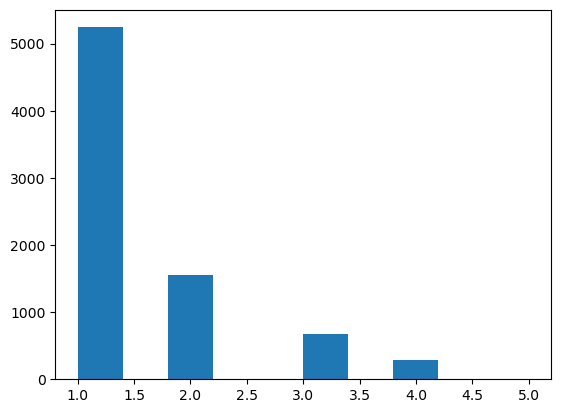

In [7]:
plt.hist(trainDF.loc[trainDF[current_col]<=4.9, current_col], range=[1,5]);

In [8]:
# Empty Dataframes for output
ivDF, woeDF = pd.DataFrame(), pd.DataFrame()

In [9]:
# Extract Column Names
feature_cols = [col for col in trainDF.columns[~trainDF.columns.isin([target_col])]]

In [10]:
# Test loop
for ivars in feature_cols:
	if ivars == current_col:
		# 1. Split continuous and categorical independent variables
		if trainDF[ivars].dtype.kind in 'bifc' and (len(np.unique(trainDF[ivars]))>10):
			binned_x = pd.cut(trainDF[ivars], bins=var_bins[ivars], duplicates='drop')
			df0 = pd.DataFrame({'Variable':binned_x, 'SeriousDlqin2yrs':trainDF[target_col]})
		else:
			df0 = pd.DataFrame({f'Variable':trainDF[ivars], 'SeriousDlqin2yrs':trainDF[target_col]})
	else: pass

df0.head(3)

,Variable,SeriousDlqin2yrs
0,"(-0.098, 1.0]",1
1,"(-0.098, 1.0]",0
2,"(-0.098, 1.0]",0


In [11]:
# 2. Count number of target events for each bin	
df0 = df0.astype({"Variable":str})
df = df0.groupby("Variable", as_index=False, dropna=False).agg({'SeriousDlqin2yrs':["count", "sum"]})

df.head(3)

Variable SeriousDlqin2yrs      
                            count   sum
0  (-0.098, 1.0]           146905  8319
1     (1.5, 4.9]             2513  1356
2   (10.0, 98.0]              285   155

In [12]:
# 3. Calculate the % of events by % of non-events
df.columns = ['QuantileRange', 'EventsCount', 'EventsSum']
df['% of Qualified'] = np.maximum(df['EventsSum'], 0.5) / df['EventsSum'].sum()
df['DelinquentCount'] = df['EventsCount'] - df['EventsSum']
df['% of Delinquent'] = np.maximum(df['DelinquentCount'], 0.5) / df['DelinquentCount'].sum()

df.head(3)

,QuantileRange,EventsCount,EventsSum,% of Qualified,DelinquentCount,% of Delinquent
0,"(-0.098, 1.0]",146905,8319,0.829743,138586,0.990084
1,"(1.5, 4.9]",2513,1356,0.135248,1157,0.008266
2,"(10.0, 98.0]",285,155,0.015460,130,0.000929


In [13]:
# 4. Calculate the WoE and IV
df['WoE'] = np.log(df['% of Delinquent']/df['% of Qualified'])
df['IV'] = df['WoE'] * (df['% of Delinquent']-df['% of Qualified'])
df.insert(loc=0, column='Variable', value=current_col)

df

,Variable,QuantileRange,EventsCount,EventsSum,% of Qualified,DelinquentCount,% of Delinquent,WoE,IV
0,NumberOfTimes90DaysLate,"(-0.098, 1.0]",146905,8319,0.829743,138586,0.990084,0.176674,0.028328
1,NumberOfTimes90DaysLate,"(1.5, 4.9]",2513,1356,0.135248,1157,0.008266,-2.794984,0.354914
2,NumberOfTimes90DaysLate,"(10.0, 98.0]",285,155,0.015460,130,0.000929,-2.812166,0.040864
3,NumberOfTimes90DaysLate,"(5.0, 9.9]",158,108,0.010772,50,0.000357,-3.406383,0.035477
4,NumberOfTimes90DaysLate,nan,139,88,0.008777,51,0.000364,-3.181786,0.026768


In [14]:
# Record values in ivDF and woeDF
temp = pd.DataFrame({"Variable":[current_col], "IV":[df['IV'].sum()]}, columns=["Variable", "IV"])
ivDF = pd.concat([ivDF, temp], axis=0)
woeDF = pd.concat([woeDF, df], axis=0)

In [15]:
print(ivDF)
woeDF

                  Variable        IV
0  NumberOfTimes90DaysLate  0.486351


,Variable,QuantileRange,EventsCount,EventsSum,% of Qualified,DelinquentCount,% of Delinquent,WoE,IV
0,NumberOfTimes90DaysLate,"(-0.098, 1.0]",146905,8319,0.829743,138586,0.990084,0.176674,0.028328
1,NumberOfTimes90DaysLate,"(1.5, 4.9]",2513,1356,0.135248,1157,0.008266,-2.794984,0.354914
2,NumberOfTimes90DaysLate,"(10.0, 98.0]",285,155,0.015460,130,0.000929,-2.812166,0.040864
3,NumberOfTimes90DaysLate,"(5.0, 9.9]",158,108,0.010772,50,0.000357,-3.406383,0.035477
4,NumberOfTimes90DaysLate,nan,139,88,0.008777,51,0.000364,-3.181786,0.026768


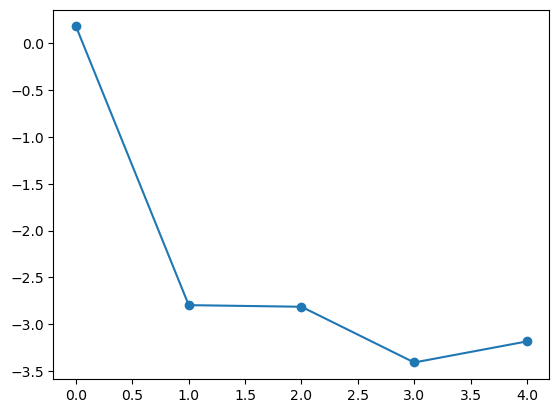

In [16]:
# plot logical trendline
plt.plot(woeDF['WoE'], marker="o");

**Sample Interpretation**

 The WoE of `NumberOfDependents` is considered a negative value because there are fewer instances where a person with one or no dependents is qualified *for a loan*. Although people with less than 2 dependents account for 70% of qualified profiles, fewer dependents is not a recommended method for determining a person's credit history. According to defined levels of Variable Predictiveness by [Siddiqi (2006)](https://www.researchgate.net/publication/349548432_Intelligent_Credit_Scoring_Building_and_Implementing_Better_Credit_Risk_Scorecards), none of the `NumberOfDependents` IV results for all bin ranges suggest that a person's dependents are not a powerful factor for determing credit history.


In [17]:
# Select target and features
target_col = 'SeriousDlqin2yrs'
feature_cols = [col for col in trainDF.columns[~trainDF.columns.isin([target_col])]]

In [18]:
# Run function
def iv_woe(data, target, features, bins, show_woe=False):
    # Empty Dataframes for output
    ivDF, woeDF = pd.DataFrame(), pd.DataFrame()
    
    for ivars in features:
        # 1. Split continuous and categorical independent variables
        if trainDF[ivars].dtype.kind in 'bifc' and (len(np.unique(trainDF[ivars]))>10):
            binned_x = pd.cut(trainDF[ivars], bins=bins[ivars], duplicates='drop')
            df0 = pd.DataFrame({'Variable':binned_x, 'SeriousDlqin2yrs':trainDF[target]})
        else:
            df0 = pd.DataFrame({f'Variable':trainDF[ivars], 'SeriousDlqin2yrs':trainDF[target]})
        # 2. Count number of target events for each bin	
        df0 = df0.astype({"Variable":str})
        df = df0.groupby("Variable", as_index=False, dropna=False).agg({'SeriousDlqin2yrs':["count", "sum"]})
        # 3. Calculate the % of events by % of non-events
        df.columns = ['QuantileRange', 'EventsCount', 'EventsSum']
        df['% of Qualified'] = np.maximum(df['EventsSum'], 0.5) / df['EventsSum'].sum()
        df['DelinquentCount'] = df['EventsCount'] - df['EventsSum']
        df['% of Delinquent'] = np.maximum(df['DelinquentCount'], 0.5) / df['DelinquentCount'].sum()
        # 4. Calculate the WoE and IV
        df['WoE'] = np.log(df['% of Delinquent']/df['% of Qualified'])
        df['IV'] = df['WoE'] * (df['% of Delinquent']-df['% of Qualified'])
        df.insert(loc=0, column='Variable', value=ivars)
        # Record values in ivDF and woeDF
        temp = pd.DataFrame({"Variable":[ivars], "IV":[df['IV'].sum()]}, columns=["Variable", "IV"])
        ivDF = pd.concat([ivDF, temp], axis=0)
        woeDF = pd.concat([woeDF, df], axis=0)
        # Show WOE Table
        if show_woe == True:
            print(df)
    
    return ivDF, woeDF

In [19]:
iv, woe = iv_woe(data=trainDF, target=target_col, features=feature_cols, bins=var_bins, show_woe=True)

                               Variable   QuantileRange  EventsCount  \
0  RevolvingUtilizationOfUnsecuredLines     (0.0, 0.49]        97178   
1  RevolvingUtilizationOfUnsecuredLines     (0.5, 0.99]        26905   
2  RevolvingUtilizationOfUnsecuredLines     (1.0, 1.49]         2715   
3  RevolvingUtilizationOfUnsecuredLines  (1.5, 60000.0]          600   
4  RevolvingUtilizationOfUnsecuredLines             nan        22602   

   EventsSum  % of Qualified  DelinquentCount  % of Delinquent       WoE  \
0       2620        0.261321            94558         0.675540  0.949764   
1       3689        0.367943            23216         0.165859 -0.796789   
2       1080        0.107720             1635         0.011681 -2.221593   
3        156        0.015560              444         0.003172 -1.590306   
4       2481        0.247457            20121         0.143748 -0.543173   

         IV  
0  0.393411  
1  0.161018  
2  0.213360  
3  0.019700  
4  0.056332  
  Variable QuantileRange  

In [20]:
iv

,Variable,IV
0,RevolvingUtilizationOfUnsecuredLines,0.843820
0,age,0.210469
0,NumberOfTime30-59DaysPastDueNotWorse,0.730876
0,DebtRatio,0.065971
0,MonthlyIncome,0.071958
0,NumberOfOpenCreditLinesAndLoans,0.000375
0,NumberOfTimes90DaysLate,0.486351
0,NumberRealEstateLoansOrLines,0.018392
0,NumberOfTime60-89DaysPastDueNotWorse,0.600050
0,NumberOfDependents,0.020041


In [21]:
woe

,Variable,QuantileRange,EventsCount,EventsSum,% of Qualified,DelinquentCount,% of Delinquent,WoE,IV
0,RevolvingUtilizationOfUnsecuredLines,"(0.0, 0.49]",97178,2620,0.261321,94558,0.675540,0.949764,0.393411
1,RevolvingUtilizationOfUnsecuredLines,"(0.5, 0.99]",26905,3689,0.367943,23216,0.165859,-0.796789,0.161018
2,RevolvingUtilizationOfUnsecuredLines,"(1.0, 1.49]",2715,1080,0.107720,1635,0.011681,-2.221593,0.213360
3,RevolvingUtilizationOfUnsecuredLines,"(1.5, 60000.0]",600,156,0.015560,444,0.003172,-1.590306,0.019700
4,RevolvingUtilizationOfUnsecuredLines,nan,22602,2481,0.247457,20121,0.143748,-0.543173,0.056332
0,age,"(18, 25]",3027,338,0.033712,2689,0.019211,-0.562396,0.008156
1,age,"(26, 34]",15019,1665,0.166068,13354,0.095403,-0.554284,0.039168
2,age,"(35, 44]",26317,2344,0.233792,23973,0.171268,-0.311206,0.019458
3,age,"(45, 64]",67502,4225,0.421404,63277,0.452063,0.070228,0.002153
4,age,"(65, 120]",28599,690,0.068821,27909,0.199387,1.063738,0.138888


## Alternative Method

In [22]:
# Load Required Packages
import pandas as pd
import category_encoders as ce

# Fit and transform a WOE encoder
encoder = ce.WOEEncoder(cols=feature_cols)
encoder.fit(trainDF[feature_cols], trainDF[target_col])
df_woe = encoder.transform(trainDF[feature_cols])

In [23]:
df_woe

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.000000,0.211753,1.617065,0.000000,1.942943,-0.213871,-0.389764,0.918438,-0.288262,0.209697
1,0.000000,0.267788,-0.541716,0.000000,0.768078,-0.045355,-0.389764,0.235979,-0.288262,0.102869
2,0.000000,0.317948,0.903810,0.000000,1.026652,0.340414,1.958062,0.235979,-0.288262,-0.139829
3,0.000000,0.527899,-0.541716,1.537478,0.619638,-0.056640,-0.389764,0.235979,-0.288262,-0.139829
4,0.000000,0.217847,0.903810,0.000000,0.000000,-0.179911,-0.389764,-0.256482,-0.288262,-0.139829
...,...,...,...,...,...,...,...,...,...,...
149995,0.000000,-0.928501,-0.541716,1.537478,0.759173,-0.045355,-0.389764,-0.256482,-0.288262,-0.139829
149996,0.000000,0.105271,-0.541716,0.000000,0.844330,-0.045355,-0.389764,-0.256482,-0.288262,0.209697
149997,0.000000,-0.353563,-0.541716,1.026652,-0.185539,0.071140,-0.389764,-0.256482,-0.288262,-0.139829
149998,-0.857203,0.527899,-0.541716,0.232082,0.764288,-0.045355,-0.389764,0.235979,-0.288262,-0.139829


## Export WoE Data Frames

In [24]:
# Export manual iv calculations
iv.to_csv('../../data/report_iv.csv')

In [25]:
# Export manual woe calculations
woe.to_csv('../../data/report_woe.csv')

In [26]:
# Export trainDF replaced with woe values calculated with categorical encoders (ce)
df_woe.to_csv('../../data/report_ce.csv')